# Problem-ML 遊戲路徑難度預測

## 題目簡介

在本題中，你的目標是預測不同遊戲路徑的難度。想像你正在設計一個遊戲關卡，需要評估你所設計路徑的難度。每條路徑都有：
- 高度變化序列（像素遊戲中的跳台高度）
- 地形特徵（森林、沙漠等）
- 環境數據（溫度、下雪等）

這條題目會測試選手做使用 [Pandas](https://pandas.pydata.org) 作特徵處理（feature engineering）的能力。題目要求選手從原始特徵（例如高度變化序列）計算數值特徵，並將這些特徵透過 Pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) 輸出為CSV，作為線性回歸模型的輸入。

前半部分：留意題目限定線性回歸模型（前 50 %），所以選手可集中做特徵工程，而不必考慮模型的複雜度。有不少部分分。

後半部分：選手可利用此 notebook 中提供的模型在訓練數據集（training dataset）上測試，並對測試數據集（testing dataset）計算一系列的特徵。Kaggle上的評分系統會根據選手提交的CSV文件與測試數據集進行線性回歸預測，並計算[R² (R-squared)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)作為評分指標。


## 競賽規則

### 1. 基本要求
- 所有特徵必須從原始資料中導出，不得額外添加非資料衍生特徵
- 輸出需符合格式（見下方）

### 2. 評分機制
- 前 50%：根據特徵工程子步驟的正確性評分（在本notebook）
- 後 50%：根據模型在測試集上的 R² 評分
- 本地可以使用訓練/驗證集進行模型調校

### 3. 檔案說明
- `train.csv`: 訓練資料，包含已知難度的路徑
- `test.csv`: 測試資料，需要預測難度

選手可打開兩個檔案查看資料結構。
它們的結構如下：

#### 共同欄位
| 欄位 | 描述 | 數據類型 | 數據取值 | 備註 |
|------------|-------------|------------|---------------------|--------|
| route_id | 路徑的唯一識別標籤 | `int` | 10000000-20000000 |  |
| name | 遊戲路徑名稱 | `str` | 例如 "Dark Journey of Light", "Mystic Trail of Light" |
| elevation_profile | 整條遊戲路徑高度變化序列 | Python List `list[float]` | 正實數（float) | _長度不固定_ |
| terrain_type | 地形 | `str` | Forest <br>Desert <br>Coastal <br>Alpine <br>Swamp <br>Grassland <br>Mountain <br>Canyon <br>Volcanic | 分類數據 (Categorical), 非均勻分佈 |
| popularity | 人氣 | `float` | 0.0-100.0 | 玩家的平均主觀評分 |
| route_type | 路徑形狀 | `str` | "out and back"（來回） 或 "loop"（環形） |
| lat | 緯度 | `float` | -90.0 to 90.0 |
| lng | 經度 | `float` | -180.0 to 180.0 |
| summer_temp | 夏天氣温 | `float` | 15.0-40.0 | Temperature in Celsius |
| winter_temp | 冬天氣温 | `float` | -30.0-15.0 | Temperature in Celsius |
| annual_rain | 年降雨量 | `float` | 0.0-2500.0 | Precipitation in mm |
| annual_snow | 年降雪量 | `float` | 0.0-1500.0 | Snowfall in mm |

#### 僅在訓練集（`test.csv`）出現
| 欄位 | 描述 | 數據類型 | 數據取值 | 備註 |
|------------|-------------|------------|---------------------|--------|
| difficulty | 路徑難度分數（目標變量） | `float` | 1.0 - 5.0 | 數值越大，難度越高

留意不同原始特徵的重要性影響路徑難度的重要性不同，部分特徵甚至幾乎沒有影響。
在此題，我們要嘗試找出適合的特徵，再對其進行適當的運算。

## 0. 初始準備
可以直接運行以下的 cells。它們 import 適當的 package。

In [2]:
"""
This cell imports necessary packages. You can directly run this cell.
"""
import numpy as np
import pandas as pd
from pandas.io.formats.style import Styler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

assert pd.__version__ >= "1.0.0", "請使用 Pandas 1.0.0 或以上版本"



In [3]:
"""
This cell implements a simple grader to test the correctness of your subtasks.
The actual grader is hidden from you, and may be different.
Do not change the code in this cell.
"""
import hashlib

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

_check_train_df = pd.read_csv('/kaggle/input/moai-2025-ml-task/train.csv')

def _sha256(s: str) -> str:
    return hashlib.sha256(str(s).encode()).hexdigest()

def grader_wrapper(func):
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except AssertionError as e:
            print(f'❌ {func.__name__}: {str(e)}')
    return wrapper

@grader_wrapper
def check_difficulty_stats(answer: str):
    assert _sha256(answer).startswith("be8bde51eeb74"), "你的答案不正確。繼續加油！"
    print('✅ 你的答案正確')

def _check_model(model: LinearRegression, hash_prefix: str):
    assert isinstance(model, LinearRegression), "model 的資料類型有誤"
    parameters = np.sort(np.append(model.coef_, model.intercept_)).round(2)
    assert _sha256(parameters).startswith(hash_prefix), "模型參數經檢查後發現你的用法不正確。繼續加油！"

@grader_wrapper
def check_popularity(model: LinearRegression):
    assert isinstance(model, LinearRegression), "`basic_model` 應是LinearRegression的實例。繼續加油！"
    assert model.metrics['r2'] < 0.01, "模型r2大得有點奇怪。繼續加油！"
    _check_model(model, "a66e5d27bb045d")
    print('✅ 你的模型正確')

@grader_wrapper
def check_length(df: pd.DataFrame, model: LinearRegression):
    assert isinstance(df, pd.DataFrame), "`train_df` 應是DataFrame。繼續加油！"
    assert isinstance(model, LinearRegression), "`model_length` 應是LinearRegression的實例。繼續加油！"
    assert 'length' in df.columns, "未有計算路徑長度並儲存在原本 DataFrame 的 'length' 欄位。繼續加油！"
    assert all(isinstance(l, int) and 0 <= l < 999999 for l in train_df['length']), \
        "'length' 欄位數值類型不正確。繼續加油！"
    assert _sha256(train_df['length']).startswith("951e92d5b144"), "'length' 計算不正確。繼續加油！"
    assert np.isclose(model.metrics['r2'], 0.3341, atol=0.01), "模型r2不正確。繼續加油！"
    _check_model(model, "94e2d9bf5790c0")
    print('✅ 你的length正確')

@grader_wrapper
def check_elevation_avg(df: pd.DataFrame):
    assert isinstance(df, pd.DataFrame), "`train_df` 應是DataFrame。繼續加油！"
    assert 'elevation_avg' in df.columns, "未有計算 'elevation_avg'。繼續加油！"
    assert _sha256(df['elevation_avg']).startswith("f165a0d2b39e31"), "'elevation_avg' 計算不正確。繼續加油！"
    print('✅ 你的elevation_avg正確')

@grader_wrapper
def check_elevation_range(df: pd.DataFrame):
    assert isinstance(df, pd.DataFrame), "`train_df` 應是DataFrame。繼續加油！"
    assert 'elevation_range' in df.columns, "未有計算 'elevation_range'。繼續加油！"
    assert _sha256(df['elevation_range']).startswith("b5427f42a7503e"), "'elevation_range' 計算不正確。繼續加油！"
    print('✅ 你的elevation_range正確')

@grader_wrapper
def check_elevation_stddev(df: pd.DataFrame):
    assert isinstance(df, pd.DataFrame), "`train_df` 應是DataFrame。繼續加油！"
    assert 'elevation_stddev' in df.columns, "未有計算 'elevation_stddev'。繼續加油！"
    assert _sha256(df['elevation_stddev']).startswith("88d56d63227931"), "'elevation_stddev' 計算不正確。繼續加油！"
    print('✅ 你的elevation_stddev正確')

@grader_wrapper
def check_elevation_change(df: pd.DataFrame):
    assert isinstance(df, pd.DataFrame), "`train_df` 應是DataFrame。繼續加油！"
    assert 'elevation_change' in df.columns, "未有計算 'elevation_change'。繼續加油！"
    assert _sha256(df['elevation_change']).startswith("089e730aa548e5"), "'elevation_change' 計算不正確。繼續加油！"
    print('✅ 你的elevation_change正確')

@grader_wrapper
def check_elevation_models(models: list[LinearRegression], model_all5: LinearRegression):
    assert isinstance(models, list) and len(models) == 4, "`models` 應該是一個包含剛好4個模型的 list。繼續加油！"
    assert all(isinstance(m, LinearRegression) for m in models), "所有模型應該是 LinearRegression 的實例。繼續加油！"
    assert isinstance(model_all5, LinearRegression), "`model_all5` 應該是 LinearRegression 的實例。繼續加油！"

    R2_PARHASH = [
        (0.1587, 'ef81417f8160'),  # elevation_avg
        (0.3058, '87b522855566'),  # elevation_range
        (0.2418, '38d14a4e4a73'),  # elevation_stddev
        (0.0071, 'd9a805dd7fa5'),  # elevation_change
        (0.5058, 'faaa6ebd7bcc'),  # combined
    ]
    _models = models + [model_all5]
    for i, (model, (r2, parhash)) in enumerate(zip(_models, R2_PARHASH)):
        assert hasattr(model, 'metrics') and 'r2' in model.metrics, \
            f"Model {i+1} missing metrics attribute"
        assert np.isclose(model.metrics['r2'], r2, atol=0.01), f"第{i+1}個模型 R² 分數不正確。繼續加油！"
        _check_model(model, parhash)

    print('✅ 你的高度變化模型正確')

@grader_wrapper
def check_terrain_features(df: pd.DataFrame):
    assert isinstance(df, pd.DataFrame), "`train_df_terrain` 應是DataFrame。繼續加油！"
    TERRAIN_SHA = {
        'Forest': '2206d0cd790b',
        'Desert': '25ad3ede4a43',
        'Coastal': '79f6e4906ec0',
        'Alpine': '126b81fe10d9',
        'Swamp': '420edb6dc2c7',
        'Grassland': 'a553faf541fb',
        'Mountain': '713f18f6f28a',
        'Canyon': '6c77b4141421',
        'Volcanic': '6939279c9590',
    }
    for terrain, sha in TERRAIN_SHA.items():
        col_name = f'terrain_type_{terrain}'
        assert col_name in df.columns, \
            f"未有創建地形類型 '{terrain}' 的 one-hot encoding 欄位 '{col_name}'。繼續加油！"
        assert _sha256(df[col_name]).startswith(sha), \
            f"地形類型 '{terrain}' 的 one-hot encoding 欄位 '{col_name}' 計算不正確。繼續加油！"
    print('✅ 你的terrain one-hot encoding正確')

@grader_wrapper
def check_terrain_model(model: LinearRegression):
    assert isinstance(model, LinearRegression), "`model_terrain` 應是LinearRegression的實例。繼續加油！"
    assert np.isclose(model.metrics['r2'], 0.1553, atol=0.01), "模型r2不正確。繼續加油！"
    _check_model(model, "5cd242a29feada")
    print('✅ 你用terrain fit的正確')

@grader_wrapper
def check_correlation_matrix(corr_matrix: pd.DataFrame):
    assert isinstance(corr_matrix, pd.DataFrame), "`correlation_matrix` 應是DataFrame。繼續加油！"
    assert corr_matrix.shape == (13, 13), "你的correlation matrix形狀不正確。繼續加油！"
    assert _sha256(corr_matrix.round(1).to_csv()).startswith("554f8b12d3955"), \
        "`correlation matrix` 計算不正確。繼續加油！"
    print('✅ 你的`correlation matrix`數值正確')

@grader_wrapper
def check_correlation_matrix_color(styler: Styler):
    assert isinstance(styler, Styler), "`colored_correlation` 類型不正確，請留意文檔。繼續加油！"
    ctx = styler._compute().ctx
    nrows, ncols = styler.data.shape
    bg = [ctx.get((r, c)) for r in range(nrows) for c in range(ncols)]
    assert _sha256(bg).startswith("e7d22eb23d78c"), \
        "`colored_correlation` matrix顏色不正確。繼續加油！"
    print('✅ 你的`colored_correlation` matrix顏色答案正確')

## 1. 資料探索

讓我們先看看資料長什麼樣子。每條路徑都有一個高度序列（elevation_profile），記錄了路徑上每個點的高度。路徑預設被讀入成一個 Python list，其每個值都是一個小數（float)。若果你偏好使用 Numpy array，可以自行轉換。

In [4]:
"""
This cell loads the training CSV and parse the elevation profile column as a list.
You can directly run this cell.
"""
train_df = pd.read_csv('/kaggle/input/moai-2025-ml-task/train.csv')
# evaluate the list encoded as str to a list
train_df['elevation_profile'] = train_df['elevation_profile'].apply(eval)
print("訓練資料預覽：")
display(train_df.head())
# display() is a convenient function in Jupyter/IPython for more interactive output than print().
# See https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.display.

訓練資料預覽：


,route_id,name,elevation_profile,terrain_type,popularity,difficulty,route_type,lat,lng,summer_temp,winter_temp,annual_rain,annual_snow
0,10308381,Shadow Path of the Moon,"[951.0, 948.7, 946.3, 943.8, 941.1, 938.4, 935...",Forest,1.7862,3.295188,out and back,37.67049,-119.62791,28.0,-13.500,330.39,482.699
1,10333191,Celestial Voyage of the Elements,"[711.7, 728.4, 743.4, 755.6, 764.6, 770.2, 772...",Alpine,5.0260,3.762766,out and back,46.99498,-121.91548,28.2,-7.896,1700.35,237.587
2,10354442,Dark Odyssey of the Titans,"[373.9, 374.5, 375.1, 375.7, 376.3, 376.9, 377...",Forest,4.4132,2.580747,out and back,43.72457,-102.52845,36.1,-19.096,355.92,83.447
3,10259298,Legendary Route of the Elders,"[599.8, 622.5, 644.2, 664.1, 681.5, 696.2, 708...",Forest,2.8908,3.855881,loop,35.75950,-83.10597,31.8,-6.896,1166.87,32.389
4,10269387,Thunder Odyssey of the Moon,"[223.7, 223.8, 224.0, 224.1, 224.3, 224.4, 224...",Forest,6.9093,2.351674,out and back,46.92654,-103.38951,32.8,-24.396,367.09,72.912


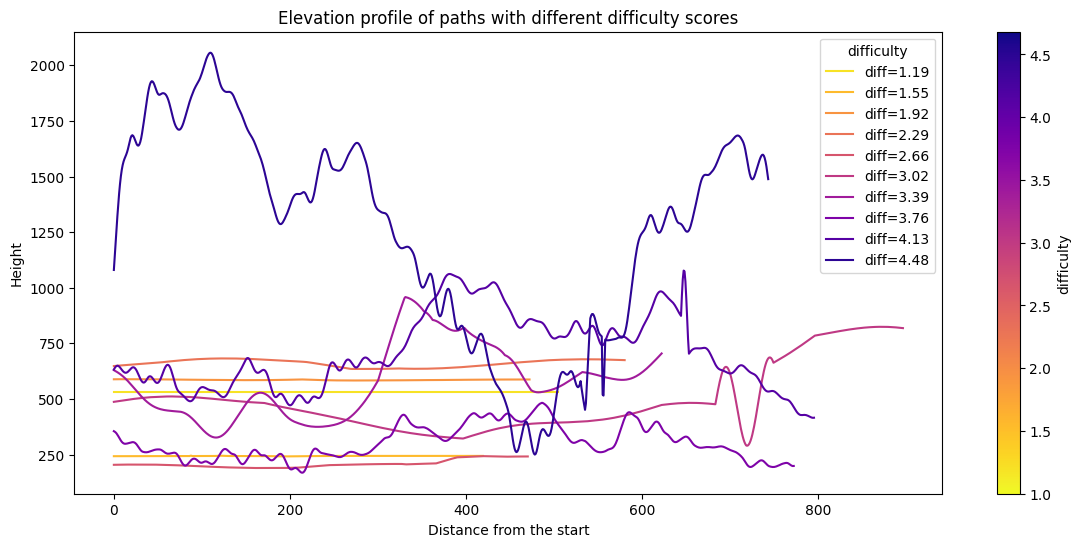

In [5]:
"""
This cell visualizes a few paths for you to get a picture of the elevation profiles.
You can directly run this cell.
"""
N_BIN = 10
min_diff, max_diff = train_df['difficulty'].min(), train_df['difficulty'].max()
bins = np.linspace(min_diff, max_diff, N_BIN+1)

# Choose a path from each bin
selected_rows = []
for i in range(N_BIN):
    bin_mask = (train_df['difficulty'] >= bins[i]) & (train_df['difficulty'] < bins[i+1])
    bin_df = train_df[bin_mask]
    if not bin_df.empty:    # pick closest to the center of the bin
        target = (bins[i] + bins[i+1]) / 2
        idx = (bin_df['difficulty'] - target).abs().idxmin()
        selected_rows.append(train_df.loc[idx])

cmap = plt.get_cmap('plasma_r')
norm = plt.Normalize(min_diff, max_diff)

fig, ax = plt.subplots(figsize=(14, 6))
for row in selected_rows:
    elevation = row['elevation_profile']
    diff = row['difficulty']
    color = cmap(norm(diff))
    plt.plot(elevation, label=f"diff={diff:.2f}", color=color)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='difficulty')

plt.title('Elevation profile of paths with different difficulty scores')
plt.xlabel('Distance from the start')
plt.ylabel('Height')
plt.legend(title="difficulty")
plt.show()

由此可見，較難的路徑明顯會有較多的「起伏」。

__題目 1.1（5分）__：現在我們來看看訓練集數據中，難度分 'difficulty' 的分布。請完成程式以生成以下形式的統計數據並儲存在 `difficulty_stats` 中，「??????」隱藏了你需要正確輸出的後幾位小數。
```markdown
count    2640.??????
mean        2.??????
std         0.??????
min         1.??????
25%         2.??????
50%         2.??????
75%         3.??????
max         4.??????
Name: difficulty, dtype: float64
```

In [6]:
# 題目1.1
# ====== OUR CODE STARTS HERE ======
tmp = train_df['difficulty']
difficulty_stats = tmp.describe()  # hint: there's a helpful function in pandas
# ======  OUR CODE ENDS HERE  ======
print(difficulty_stats)

check_difficulty_stats(difficulty_stats)  # grader, no need to change

count    2640.000000
mean        2.845611
std         0.625036
min         1.000000
25%         2.414136
50%         2.843485
75%         3.302190
max         4.680615
Name: difficulty, dtype: float64
✅ 你的答案正確


## 2. 特徵工程 - 第一步：建立直覺

**題目 2.1（5分）**：在開始特徵工程之前，我們先試試直接使用不同的特徵進行回歸。下一個 cell 有一個簡單的線性迴歸函數。請嘗試使用該函數，利用數據集內 _'popularity'_ 欄位估算 'difficulty'。

In [7]:
"""
This cell implements a simple linear regression model to predict difficulty.
You can directly invoke this function by providing the desired features to be used.
You can but do not need to change the code in this cell.
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

def train_linear_model(df: pd.DataFrame, feature_columns: list[str], verbose: bool = True) -> LinearRegression:
    """
    Train a linear regression model on the specified dataframe and columns.

    Args:
        df (pd.DataFrame): Input dataframe containing features and 'difficulty' column
        feature_columns (list): List of column names to use as features
        verbose (bool): Whether to print training logs

    Returns:
        LinearRegression: Trained model

    Example:
        model = train_linear_model(
            df=train_df,
            feature_columns=['popularity', 'summer_temp', 'winter_temp']
        )
    """
    # Input validation
    if not isinstance(df, pd.DataFrame):
        raise ValueError("`train_linear_model` 提供的 `df` 參數應要是 pandas.DataFrame！繼續加油。")
    if not isinstance(feature_columns, list):
        raise ValueError("`train_linear_model` 提供的 `feature_columns` 參數應要是用到的特徵的名字的list！繼續加油。")
    if 'difficulty' not in df.columns:
        raise ValueError("`train_linear_model` 提供的 DataFrame 要包含 'difficulty' 欄位來擬合線性迴歸模型！繼續加油。")
    missing_cols = [col for col in feature_columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"`train_linear_model` 提供的 DataFrame 要包含以下欄位: {missing_cols}！繼續加油。")

    X = df[feature_columns]
    y = df['difficulty']

    # Train model, make predictions
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Calculate metrics
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    model.metrics = {'r2': r2, 'mse': mse}

    if verbose:     # Print training logs
        print("\n模型訓練結果:")
        print(f"R² Score: {r2:.4f}")
        print(f"Mean-Squared Error: {mse:.4f}")

        print("\n模型參數 (coefficients + intercept):")
        coef_df = pd.DataFrame({
            'Feature': feature_columns + ['Intercept'],
            'Coefficient': list(model.coef_) + [model.intercept_]
        })
        display(coef_df)

    return model

In [8]:
# 題目2.1
# ====== OUR CODE STARTS HERE ======
basic_features = ['popularity']    # TODO
basic_model: LinearRegression = None   # TODO, tip below
basic_model = train_linear_model(df = train_df, feature_columns = basic_features)
# ======  OUR CODE ENDS HERE  ======

check_popularity(basic_model)  # grader, no need to change


模型訓練結果:
R² Score: 0.0033
Mean-Squared Error: 0.3892

模型參數 (coefficients + intercept):


,Feature,Coefficient
0,popularity,-0.004411
1,Intercept,2.884968


✅ 你的模型正確


[R²分數](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)是決定係數，或稱判定係數（Coefficient of determination），在統計學中用於度量應變量的變異中可由自變量解釋部分所佔的比例，以此來判斷迴歸模型的解釋力。R²的值在 [0,1] 上，一般來說越高代表模型越好。

看來只有人氣不足以判斷遊戲路徑難度，因為R²值少於0.01。

讓我們思考：什麼樣的路徑會比較難？例如：
1. *高度變化大的路徑*
   - 需要更多跳躍
   - 可能有更陡的坡度

2. *連續上坡或下坡*
   - 消耗玩家更多體力

**問題 2.2（5分）**：讓我們從簡單的特徵開始嘗試！例如，嘗試從 'elevation_profile' 計算路徑的長度。詳細來說：
* 計算 'elevation_profile' 的長度，並把它儲存在原 Dataframe 的一個新的 column，名為 'length'。
* 使用 `train_linear_model` 和 'length' 擬合線性迴歸模型。

到底路徑長度對難度的影響有多大呢？

Note: 若選手希望的話，已經可以跳到第4節提交一個初步答案。

In [9]:
# 題目2.2
# ====== OUR CODE STARTS HERE ======
length_model: LinearRegression = None # TODO

tmp = train_df['elevation_profile']
leth=[]
for i in tmp:
    leth.append(len(i))

train_df['length'] = leth
length_model = train_linear_model(df = train_df, feature_columns = ['length'])
# ======  OUR CODE ENDS HERE  ======

check_length(train_df, length_model)  # grader, no need to change


模型訓練結果:
R² Score: 0.3341
Mean-Squared Error: 0.2601

模型參數 (coefficients + intercept):


,Feature,Coefficient
0,length,0.003477
1,Intercept,0.488487


✅ 你的length正確


__問題2.3.1（10分）__：高度特徵分析

高度變化是影響難度的 _最重要因素_。請從每條路徑的高度變化序列（elevation profile）計算以下統計特徵：
1. 平均高度：儲存在 `train_df` 的 'elevation_avg'
2. 高度範圍（最高點與最低點的差）：儲存在 `train_df` 的 'elevation_range'
3. 高度標準差：儲存在 `train_df` 的 'elevation_stddev'
4. 終點-起點的高度：儲存在 `train_df` 的 'elevation_change'

In [ ]:
# 題目2.3.1
# ====== YOUR CODE STARTS HERE ======
tmp = train_df['elevation_profile']
avg_h =[]
range_h = []
std_h = []
ele_h = []

for i in tmp:
    cnt=0
    fc = 0
    tmp_avg = sum(i)/len(i)
    tmp_sum = 0
    for k in i:
        tmp_sum += (k - tmp_avg)**2
    fc = tmp_sum/len(i)
    avg_h.append(tmp_avg)
    range_h.append(max(i)-min(i))
    std_h.append(fc**0.5)
    ele_h.append(i[len(i)-1]-i[0])
    

train_df['elevation_avg'] = avg_h
train_df['elevation_range'] = range_h
train_df['elevation_stddev'] = std_h
train_df['elevation_change'] = ele_h

# ====== YOUR CODE ENDS HERE ======

display(train_df)
# graders, no need to change
check_elevation_avg(train_df)
check_elevation_range(train_df)
check_elevation_stddev(train_df)
check_elevation_change(train_df)

__問題2.3.2（5分）__：使用高度特徵

利用上述四個獨立擬合4個模型，以測試它們的合適程度。最後再擬合一個模型同時利用上述4個特徵和 'length'。

建議在開始之前思考上述的特徵直觀上可以有多準確判斷難度，以助後面創建其他特徵/選擇不同特徵組合。

In [ ]:
# 題目2.3.2
# ====== YOUR CODE STARTS HERE ======
elevation_models: list[LinearRegression] = []  # TODO: a list of 4 linear regression models, in order
elevation_models = [train_linear_model(df = train_df, feature_columns = ['elevation_avg']),
                     train_linear_model(df = train_df, feature_columns = ['elevation_range']),
                     train_linear_model(df = train_df, feature_columns = ['elevation_stddev']),
                     train_linear_model(df = train_df, feature_columns = ['elevation_change'])
                    ]

#avg_model = train_linear_model(df = train_df, feature_columns = ['elevation_avg'])
#range_model = train_linear_model(df = train_df, feature_columns = ['elevation_range'])
#stddev_model = train_linear_model(df = train_df, feature_columns = ['elevation_stddev'])
#change_model = train_linear_model(df = train_df, feature_columns = ['elevation_change'])

elevation_model_all5: LinearRegression = None   # TODO: the linear regression model that uses all 5 features
elevation_model_all5 = train_linear_model(df = train_df, feature_columns = ['elevation_change', 'elevation_stddev', 'elevation_range','elevation_avg', 'length'])

# ======  YOUR CODE ENDS HERE  ======

check_elevation_models(elevation_models, elevation_model_all5)

__問題 2.4（10分）__：地形分析

運下以下的 cell 計算不同地形（**terrain**）的基本統計數據。

接着，讓我們創建一個基於地形的預測模型。
1. 使用 **0-1 (非 True-False)** one-hot encoding（因為字串不能被直接用來擬合模型）
2. 訓練線性回歸模型
3. 分析每種地形對難度的影響程度

In [ ]:
# Run the cell below to see the terrain type distribution
terrain_stats = train_df.groupby('terrain_type')['difficulty'].agg(['mean', 'count', 'std'])
print("\n各地形統計：")
display(terrain_stats.sort_values('mean', ascending=False))

In [ ]:
# 題目2.4
# Create new one-hot encoding columns from `terrain_type`.
# They should be named `terrain_type_[type]`, such as `terrain_type_Mountain`, `terrain_type_Alpine`, etc.
# For example, 'terrain_type_Forest' should be 1 if the path is a forest, and 0 otherwise.

# ====== YOUR CODE STARTS HERE ======
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df_terrain: pd.DataFrame = None    # TODO

train_df['terrain_type'] = le.fit_transform(train_df['terrain_type'])
#train_df_terrain = train_df['terrain_type']
train_df_terrain = train_df.groupby('terrain_type')
# ======  YOUR CODE ENDS HERE  ======

display(train_df_terrain)
check_terrain_features(train_df_terrain) # grader, no need to change

In [ ]:
# 題目2.4
# Use all one-hot encoding columns to fit a model

# ====== YOUR CODE STARTS HERE ======
terrain_model: LinearRegression = None   # TODO
terrain_model = train_linear_model(df = train_df, feature_columns = ['terrain_type'])
# ======  YOUR CODE ENDS HERE  ======

check_terrain_model(terrain_model)   # grader, no need to change

可見，地形（terrain）對路徑的難度有不少影響，但只有地形不足夠。在後續的第三部分，我們會考慮整合上面考慮過的不同特徵，甚至你自己創造的特徵。

同時，留意迴歸模型每個特徵系數的正負。你覺得它們合理嗎？和上面地形統計一致嗎？

--------
（不計分）若果我們一次過用所有的數字特徵呢？

思考：R2 分數是 1.0？！完美的模型？？有甚麼部分出錯了嗎？

In [ ]:
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
all_model = train_linear_model(train_df, numeric_cols)

-------
__問題 2.5（10分）__：相關性 (**correlation**) 分析

讓我們深入了解各個數值特徵之間的關係。計算以下特徵之間的相關性矩陣（按順序）：
- difficulty（目標變量）
- length
- elevation_avg
- elevation_range
- elevation_stddev
- elevation_change
- lat
- lng
- popularity
- summer_temp
- winter_temp
- annual_rain
- annual_snow

使用 `Dataframe.style.background_gradient` 來視覺化相關性矩陣。這將幫助我們理解哪些特徵與難度最相關。請使用 Red-Blue diverging（RdBu）顏色圓（colormap）。請把 `vmin` 和 `vmax` 參數分別設成相關性的最小與最大可能取值。

提示：相關性的數值範圍是？

In [ ]:
# 題目2.5
# ====== YOUR CODE STARTS HERE ======
correlation_matrix = None   # fill in here
# ======  YOUR CODE ENDS HERE  ======

# Give a background color to every cell of the correlation matrix
def style_corr_matrix(correlation_matrix: pd.DataFrame) -> Styler:
    # Create a styled DataFrame from correlation_matrix
    # ====== YOUR CODE STARTS HERE ======
    styled_correlation = correlation_matrix    # TODO
    # ======  YOUR CODE ENDS HERE  ======
    
    return styled_correlation

# Display the correlation matrix: `display` can show cells with background colors
colored_correlation = style_corr_matrix(correlation_matrix)
display(colored_correlation)

# grader, no need to change
check_correlation_matrix(correlation_matrix)
check_correlation_matrix_color(colored_correlation)

可以思考這些相關性和使用這些特徵作feature的好壞的聯繫。你也可以進一步考慮更多初始/間接特徵之間的相關性。

## 3. 特徵工程 - 進階

我們已經對數據集不同原始特徵有一定的理解。在這一部分我們會做題目後 50% 的評分。請繼續思考影響題目的直接特徵或從直接特徵能計算出來的間接特徵。大膽假設，小心求證。

現在，我們會寫一個叫 `compute_features` 的函數。給定一個遊戲路徑的 Pandas Dataframe，它可以計算新的特徵並儲存在新的欄位（或更改已有特徵）。這樣做的好處是當我們在測試數據集上計算時毋須重新寫特徵計算的邏輯。若有需要，你可以額外創建合適的變量與函數。

In [ ]:
def compute_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute new features from raw features in `df` that we can use to fit a
    linear regression model to compute 'difficulty'.
    """
    # ====== OUR CODE STARTS HERE ======
    pass
    # ======  OUR CODE ENDS HERE  ======
    return df

# Try different combinations of features on training data set
# ====== OUR CODE STARTS HERE ======
pass
# ======  OUR CODE ENDS HERE  ======

In [10]:
#other model
# 区域1：库导入========================================================
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import (accuracy_score, precision_score, 
                            recall_score, f1_score, fbeta_score)
import joblib

# 区域2：路径配置=====================================================
TRAIN_PATH = "/kaggle/input/moai-2025-ml-task/train.csv"  # 带标签的训练集
TEST_PATH = "/kaggle/input/moai-2025-ml-task/test.csv"    # 仅特征的测试集
OUTPUT_PATH = "/kaggle/working/predictions.csv"  # 结果文件路径

# 区域3：数据加载与预处理=============================================
# 加载训练集（含标签）
train_data = pd.read_csv(TRAIN_PATH)
X = train_data.drop(['route_id','name','difficulty'],axis=1)  
y = train_data['difficulty']


# 定义特征类型（根据实际数据修改）
numeric_features = X.select_dtypes(include=['number']).columns  # 数值型特征示例
categorical_features = X.select_dtypes(include=['object']).columns       # 类别型特征示例

# 构建预处理管道
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),      # 标准化数值特征
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_features)  # 独热编码
    ])

# 构建完整管道
# 原代码中的管道定义修改为：
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GridSearchCV(  # 替换原有回归器为网格搜索
        estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
        param_grid={
            'n_estimators': [100, 200, 300],  # 树数量候选值[5,6](@ref)
            'max_depth': [10, 15, 20,30],        # 深度候选值[5,7](@ref)
            'min_samples_split': [2, 5, 10],      # 节点分裂最小样本数[3](@ref)
            'max_features': ['sqrt', 'log2']  # 特征选择方式[8](@ref)
        },
        cv=5,                # 5折交叉验证[6,7](@ref)
        scoring='neg_mean_squared_error',  # 与MSE指标一致[4,6](@ref)
        verbose=2,           # 显示训练进度
        n_jobs=-1            # 使用全部CPU核心[5](@ref)
    ))
])

# 划分验证集
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 训练模型
pipeline.fit(X_train, y_train)

# 获取最佳模型参数和得分
best_params = pipeline.named_steps['regressor'].best_params_  # 最佳参数[6,7](@ref)
best_score = -pipeline.named_steps['regressor'].best_score_   # 转为正MSE[4](@ref)

# 用最佳模型进行验证集预测
val_pred = pipeline.predict(X_val)
print(f"最佳参数：{best_params}")
print("验证集MSE:", mean_squared_error(y_val, val_pred))


test_data = pd.read_csv(TEST_PATH)
ids = test_data['route_id']  


# 生成预测结果
predictions = pipeline.predict(test_data)

# 构建结果数据框
output_df = pd.DataFrame({
    'route_id': ids,
    'difficulty': predictions
})

#output_df['close'] = output_df['close'].round(1)

# 导出预测结果
output_df.to_csv(OUTPUT_PATH, index=False, header=True)

# 保存完整管道
best_model = pipeline.named_steps['regressor'].best_estimator_
joblib.dump(best_model, '/kaggle/working/best_model.pkl')

print(f"预测结果已保存至：{OUTPUT_PATH}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=10, max_features=sq

## 4. 生成提交檔案

最後一步！讓我們生成提交檔案。我們只需使用同樣的原理，在測試數據集上計算所需特徵，fit 線性迴歸模型，再把 difficulty 的預測輸出到 `submission.csv` 即可。`submission.csv` 需有兩個欄位：'route_id' 和（選手預測的）'difficulty'。選手可從 `submission_sample.csv` 查看提交格式的例子。

提交後 Kaggle 會自動按你的 R² 評分。請於下表見 R² 與分數之間的關係。留意 Kaggle 上提供的分數僅供參考。最終得分是在某更大的隱藏數據集上測試。

| R² 範圍 | 分數計算方式 |
|-----------------|-----------------------------------|
| 0 ~ 0.25 | 0 |
| 0.25 ~ 0.55 | $x - 0.25$ |
| 0.55 ~ 0.8 | $1.1 \sqrt{x - 0.55} + 0.3$ | 
| 0.8 ~ 1 | $0.75x + 0.25$ |

若時間允許，選手可以回到上面某些 cell 嘗試不同的特徵組合。你甚至可以完全使用線性回歸以外的模型。Good luck!

In [ ]:
"""
This cell contains code to plot the scoring curve.
You can run this cell directly.
"""
def score_func(x):
    x = np.asarray(x)
    y = np.zeros_like(x)
    # 0.25 < x <= 0.55
    mask1 = (x > 0.25) & (x <= 0.55)
    y[mask1] = (x[mask1] - 0.25)
    # 0.55 < x <= 0.8
    mask2 = (x > 0.55) & (x <= 0.8)
    y[mask2] = 1.1 * (x[mask2] - 0.55)**0.5 + 0.3
    # 0.8 < x <= 1
    mask3 = (x > 0.8) & (x <= 1)
    y[mask3] = 0.75 * x[mask3] + 0.25
    return y

x = np.linspace(0, 1, 500)
y = score_func(x)
plt.figure(figsize=(8, 4))
plt.plot(x, y, label='Score vs R²')
for line in (0.25, 0.55, 0.8):
    plt.axvline(line, color='gray', linestyle='--', alpha=0.5)
plt.title('R² to Final Score')
plt.xlabel('R²')
plt.ylabel('Final Score')
plt.grid(True, linestyle=':')
plt.show()

In [ ]:
# 題目4. TODO
# ====== OUR CODE STARTS HERE ======
# Read the test dataset
test_df = pd.read_csv('/kaggle/input/moai-2025-ml-task/train.csv')
# Compute features you like
tmp = test_df['elevation_profile']
leth=[]
for i in tmp:
    leth.append(len(i))
test_df['length'] = leth
test_t = test_df['route_id','length']
# ======  OUR CODE ENDS HERE  ======

提示：`train_linear_model()` 會返回擬合過的線性迴歸模型（類型為 [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)）。[`model.predict()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict)（[文檔](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict)） 可以用 `model` 模型在任意 input（例如測試數據集）上 predict 答案。
提示2:Grader會要求你輸出的 'difficulty' 在 1-5 的範例裏。可以考慮用 `.clip()`（[NumPy文檔](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.clip.html)、[Pandas文檔](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.clip.html)）函數把線性迴歸超出範圍的輸出限在 1-5 內。

In [ ]:
# 題目4. TODO
# ====== OUR CODE STARTS HERE ======
# Use the regression model from 3. to predict difficulty

test_predictions = length_model.predict(test_df['length'])

# Write output to submission.csv. Make sure your format is right.
ids = test_df['route_id']
output_df = pd.DataFrame({
    'route_id': ids,
    'close': difficulty
})
output_df.to_csv(OUTPUT_PATH, index=False, header=True)
# ======  OUR CODE ENDS HERE  ======

## 提交檢查清單 ✅

在提交之前，請確保：
- [ ] 所有特徵提取函數都已實現
- [ ] 特徵矩陣不包含 NaN 值
- [ ] 提交檔案格式正確

祝你好運！🍀